# **Prediksi Harga Saham NVDA dengan Pendekatan Multi-Model Time Series dengan membandingkan Model LSTM, GRU, dan CNN**
Dataset yang akan digunakan adalah data asli saham seperti harga dan volatilitas yang didapatkan dari yahoo finance yang di download menggunakan module yfinance https://finance.yahoo.com/. Tujuan dari proyek ini yaitu untuk meneliti seberapa akurat prediksi harga saham dengan membandingkan beberapa model machine learning seperti LSTM, GRU, Random Forest kemudian dibandingkan dengan harga aslinya saham tersebut pada periode tertentu.

Untuk investasi sendiri memerlukan pertimbangan yang matang dari beberapa aspek analisa, oleh karena itu prediksi time forecasting pada proyek ini tidak dapat dijadikan satu-satunya indikator acuan untuk memutuskan untuk berinvestasi melainkan dapat menjadi salah satu pertimbangan indikator. Agar dapat menambahkan indikator lainnya maka dapat juga memanfaatkan machine learning dengan dibuatnya proyek analisis sentiment berdasarkan forum saham atau analisis sentimen berita terkait suatu saham, tetapi proyek kali ini hanya membuat dan melatih model untuk tujuan prediksi harga closing saja.

# **1. Import Library**

In [ ]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 699.0 kB/s eta 0:00:04
     ------ --------------------------------- 0.5/3.0 MB 699.0 kB/s eta 0:00:04
     ---------- ----------------------------- 0.8/3.0 MB 671.3 kB/s eta 0:00:04
     ---------- ----------------------------- 0.8/3.0 MB 671.3 kB/s eta 0:00:04
     ------------- -------------------------- 1.0/3.0 MB 606.3 kB/s eta 0:00:04
     ------------- -------------------------- 1.0/3.0 MB 606.3 kB/s eta 0:00:04
     ------------- -------------------------- 1.0/3.0 MB 606.3 kB/s eta 0:00:04
     ----------------- ---------------------- 1.3/3.0 MB 573.6 kB/s eta 0:00:03
     

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten,Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# **2. Download Dataset**
Download dataset dari yfinance, ticker dapat diganti menjadi kode saham yang tersedia di https://finance.yahoo.com/. tetapi saat ini akan digunakan saham Nvidia(NVDA).

In [26]:
ticker = "NVDA"
df = yf.download(ticker, start="2018-01-01", end="2025-04-24")

# Handle MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

df.reset_index(inplace=True)
df.columns.name = None

[*********************100%***********************]  1 of 1 completed


In [27]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2018-01-02,4.929428,4.933138,4.809500,4.841151,355616000
1,2018-01-03,5.253853,5.284268,5.038229,5.046884,914704000
2,2018-01-04,5.281548,5.391833,5.259293,5.335207,583268000
3,2018-01-05,5.326304,5.363643,5.219481,5.296384,580124000
4,2018-01-08,5.489507,5.563690,5.404939,5.449943,881216000


# **3. Exploratory Data Analysis (EDA)**

Pada tahap ini, dilakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Menangani data yang hilang jika ada dengan pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif.  

4. **Visualisasi Data**  
   - Terdapat visualisasi harga close dan volume.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [28]:
print("=== Data Shape ===")
df.shape

=== Data Shape ===


(1837, 6)

In [5]:
print("--- Info Data Saham NVDA ---")
df.info()

--- Info Data Saham NVDA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1837 non-null   datetime64[ns]
 1   Close   1837 non-null   float64       
 2   High    1837 non-null   float64       
 3   Low     1837 non-null   float64       
 4   Open    1837 non-null   float64       
 5   Volume  1837 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 86.2 KB


Fitur :
- Date(datetime) = Tanggal pencatatan harga saham tersebut.
- Open(float) = Harga buka bursa saham dihari itu.
- High(float) = Harga tertinggi saham di hari itu.
- Low(float) = Harga saham terendah di hari itu.
- Close(float) = Harga terakhir saham dihari tersebut karena bursa sudah tutup.
- Volume(int) = Volume saham yang diperdagangkan pada hari tersebut.

In [6]:
print("=== Duplicate Check ===")
print(f"{ticker}: {df.duplicated().sum()} duplikat")

=== Duplicate Check ===
NVDA: 0 duplikat


In [7]:
print("=== Missing Values ===")
df.isna().sum()

=== Missing Values ===


,0
Price,
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [8]:
print(df.describe())

Price                           Date        Close         High          Low  \
count                           1837  1837.000000  1837.000000  1837.000000   
mean   2021-08-25 22:47:52.945019136    32.755910    33.385452    32.077996   
min              2018-01-02 00:00:00     3.151139     3.223049     3.086172   
25%              2019-10-29 00:00:00     6.206632     6.287338     6.132600   
50%              2021-08-25 00:00:00    15.392447    15.709118    15.105756   
75%              2023-06-23 00:00:00    40.999619    41.995070    40.462244   
max              2025-04-23 00:00:00   149.416245   153.115916   147.806407   
std                              NaN    39.640494    40.437032    38.810036   

Price         Open        Volume  
count  1837.000000  1.837000e+03  
mean     32.770435  4.557821e+08  
min       3.136509  9.788400e+07  
25%       6.217360  3.074400e+08  
50%      15.364904  4.191680e+08  
75%      41.067966  5.570490e+08  
max     153.015919  2.511528e+09  
std     

Output kode tersebut memberikan informasi:
- Count adalah jumlah sampel pada data.
- Mean adalah nilai rata-rata.
- Min yaitu nilai minimum setiap kolom.
- 25% adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- 50% adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
- 75% adalah kuartil ketiga.
- Max adalah nilai maksimum.
- Std adalah standar deviasi.

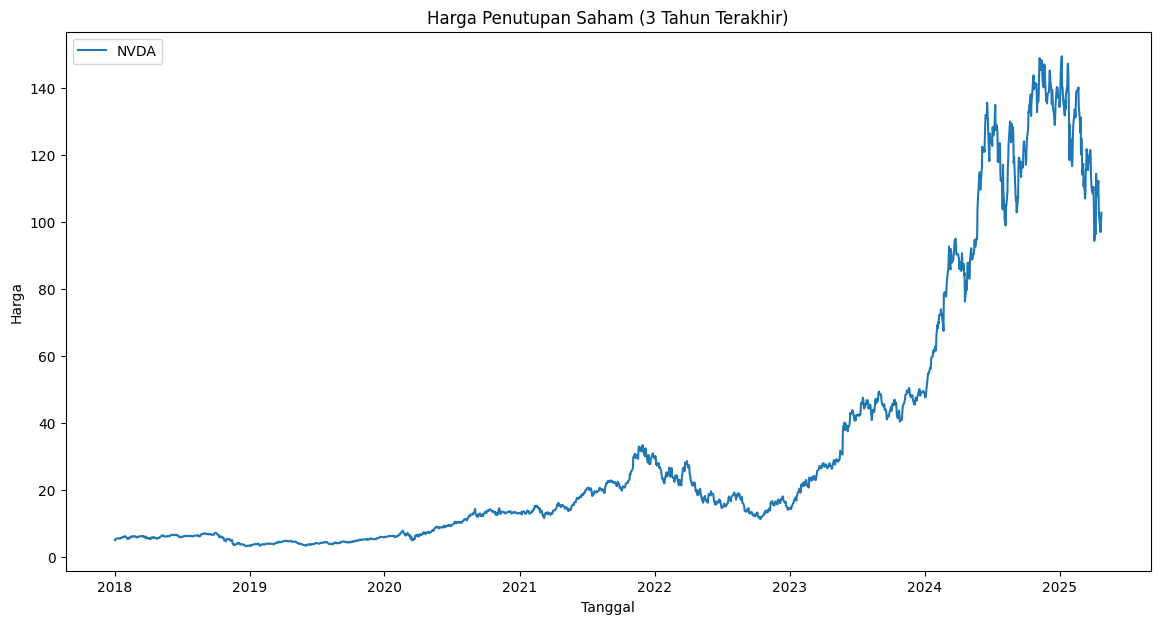

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label=ticker)
plt.title('Harga Penutupan Saham (3 Tahun Terakhir)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

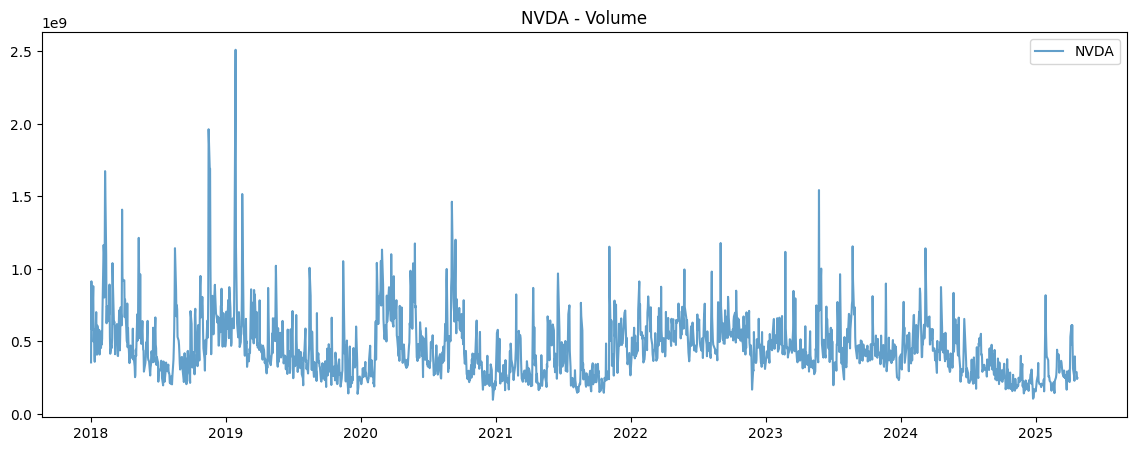

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Volume'],
label='NVDA', alpha=0.7)
plt.title(f'{ticker} - Volume')
plt.legend()
plt.show()

**Insight:**
- Semua data valid: tak ada null, duplikat, atau outlier ekstrim.
- Data melebihi ketentuan dari data yang diambil dari periode: 2018‑01‑01 hingga 2025‑04‑24 (terdapat 1.837 baris, ≥500 sampel).
- Fitur Data terdiri dari :
Date = Tanggal pencatatan harga saham tersebut, Open = Harga buka bursa saham dihari itu, High = Harga tertinggi saham di hari itu, Low = Harga saham terendah di hari itu, Close = Harga terakhir saham dihari tersebut karena bursa sudah tutup, Volume = Volume saham yang diperdagangkan pada hari tersebut.

# **4. Pembangunan Model**
Untuk training akan menggunakan data train dan validasi, kemudian untuk membandingkan kualitas model yang telah ditraining akan dibandingkan dengan data test. Data test akan digunakan juga untuk melakukan inferensi dengan membandingkan hasil prediksi model dengan harga asli saham.

Akan dilakukan 3 perbandingan model yaitu LSTM, GRU, dan CNN sebagai pembanding kasus Time Series Forecasting.

In [11]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

# Membuat Dataset Time Series sliding window
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_dataset(scaled_data, time_steps)

# Split Data 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

# Reshape format input
#    Untuk RNN dan CNN: (samples, time_steps, 1)
X_train_rnn = X_train.reshape(-1, time_steps, 1)
X_val_rnn   = X_val.reshape(-1, time_steps, 1)
X_test_rnn  = X_test.reshape(-1, time_steps, 1)

In [12]:
all_dates = df['Date'].iloc[time_steps:].reset_index(drop=True)
n_train = len(X_train)
n_val   = len(X_val)
n_test  = len(X_test)

train_dates = all_dates.iloc[:n_train]
val_dates   = all_dates.iloc[n_train:n_train+n_val]
test_dates  = all_dates.iloc[n_train+n_val:n_train+n_val+n_test]

print(f"Train period:      {train_dates.iloc[0].date()} to {train_dates.iloc[-1].date()}")
print(f"Validation period: {val_dates.iloc[0].date()} to {val_dates.iloc[-1].date()}")
print(f"Test period:       {test_dates.iloc[0].date()} to {test_dates.iloc[-1].date()}")

Train period:      2018-03-29 to 2023-03-07
Validation period: 2023-03-08 to 2024-03-28
Test period:       2024-04-01 to 2025-04-23


In [13]:
# Eksperimen 1: LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(time_steps, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0021 - val_loss: 9.8727e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5868e-04 - val_loss: 6.5576e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1045e-04 - val_loss: 9.7571e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0691e-04 - val_loss: 0.0013
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6848e-05 - val_loss: 7.2962e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7508e-05 - val_loss: 5.6524e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6716e-05 - val_loss: 7.6614e-04
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0235e-05 - val_loss: 0.0014
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.0678e-05 - val_loss: 9.4537e-04
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.0261e-05 - val_loss: 6.2635e-04
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8016e-05 

Training model lstm berhenti di epoch 16 dari 100 berkat earlystop yang memonitor val_loss.

In [14]:
# Eksperimen 2: GRU
model_gru = Sequential()
model_gru.add(GRU(64, return_sequences=True, input_shape=(time_steps, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()

history_gru = model_gru.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0017 - val_loss: 8.1856e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0375e-05 - val_loss: 2.7337e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1845e-05 - val_loss: 3.7336e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7744e-05 - val_loss: 7.0843e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2784e-05 - val_loss: 2.0037e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0074e-05 - val_loss: 2.7013e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5115e-05 - val_loss: 3.3445e-04
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0350e-05 - val_loss: 5.1281e-04
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3440e-05 - val_loss: 3.7336e-04
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3344e-05 - val_loss: 4.0052e-04
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.2091

Training model gru berhenti di epoch 41 dari 100 berkat earlystop yang memonitor val_loss.

In [15]:
# Eksperimen 3: CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(time_steps,1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(32, kernel_size=3, activation="relu"))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation="relu"))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.summary()

history_cnn = model_cnn.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,809 (77.38 KB)

 Trainable params: 19,809 (77.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3398e-04 - val_loss: 0.0079
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5945e-04 - val_loss: 0.0066
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5785e-04 - val_loss: 0.0076
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1387e-04 - val_loss: 0.0056
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5589e-04 - val_loss: 0.0052
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7216e-04 - val_loss: 0.0037
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6822e-04 - val_loss: 0.0028
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6033e-04 - val_loss: 0.0025
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4337e-04 - val_loss: 0.0051
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8107e-04 - val_loss: 0.0019
Epoch 12/100
39/39 ━━━

Training model lstm berhenti di epoch 28 dari 100 berkat earlystop yang memonitor val_loss.

# **5. Evaluasi, Export, dan Inferensi Model**

In [16]:
# Fungsi inverse scaling
def inv_scale(arr):
    return scaler.inverse_transform(arr.reshape(-1,1)).flatten()

# Evaluasi di test set
y_test_act = inv_scale(y_test)

def eval_model(name, y_true, y_pred_scaled):
    y_pred = inv_scale(y_pred_scaled.flatten())
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name:4s} → MAE: {mae:7.4f} | RMSE: {rmse:7.4f}")
    return rmse

In [17]:
print("\n=== Test Set Metrics ===")
rmse_lstm = eval_model("LSTM", y_test_act, model_lstm.predict(X_test_rnn))
rmse_gru  = eval_model("GRU",  y_test_act, model_gru.predict(X_test_rnn))
rmse_cnn  = eval_model("CNN",  y_test_act, model_cnn.predict(X_test_rnn))


=== Test Set Metrics ===
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM → MAE: 10.7397 | RMSE: 12.6856
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
GRU  → MAE:  3.8096 | RMSE:  4.9507
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
CNN  → MAE: 14.0640 | RMSE: 16.1201


MAE mengukur rata-rata kesalahan absolut: semakin kecil, semakin baik.

RMSE menyoroti kesalahan yang lebih besar secara kuadrat, memberi penalti lebih tinggi pada outlier.

Semakin kecil MAE dan RMSE maka model tersebut bekerja dengan baik. Dari score perbandingan RMSE dan MAE diatas diperoleh bahwa GRU merupakan model terbaik.

In [18]:
# Pilih terbaik berdasarkan RMSE
rmse_scores = {"LSTM": rmse_lstm, "GRU": rmse_gru, "CNN": rmse_cnn}
best_model = min(rmse_scores, key=rmse_scores.get)
print(f"\nOverall best model: {best_model}")


Overall best model: GRU


In [19]:
# Export model
model_lstm.save("model_lstm.h5")
model_gru.save("model_gru.h5")
model_cnn.save("model_cnn.h5")
print("\nExported: model_lstm.h5, model_gru.h5, model_cnn.h5")


Exported: model_lstm.h5, model_gru.h5, model_cnn.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


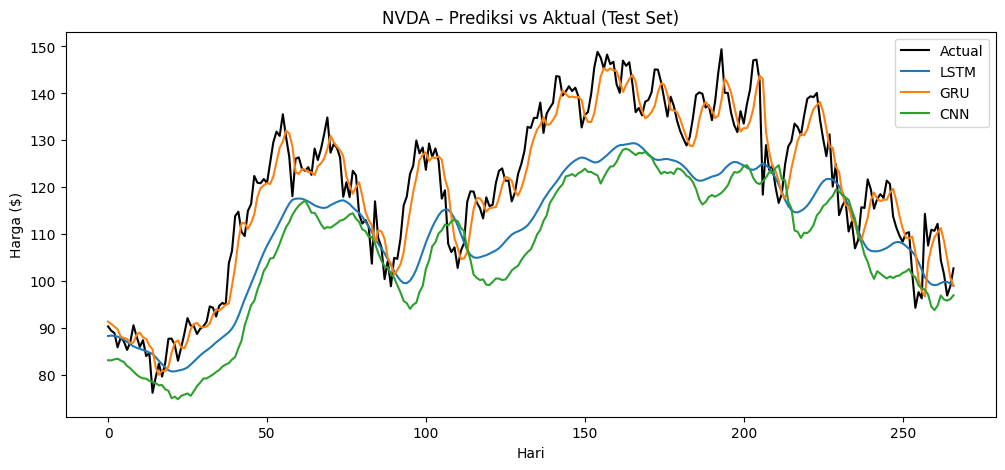

In [20]:
# Plot perbandingan actual vs prediksi semua model
plt.figure(figsize=(12,5))
plt.plot(y_test_act, label="Actual", color="black")
plt.plot(inv_scale(model_lstm.predict(X_test_rnn)), label="LSTM")
plt.plot(inv_scale(model_gru.predict(X_test_rnn)),  label="GRU")
plt.plot(inv_scale(model_cnn.predict(X_test_rnn)),  label="CNN")
plt.title(f"{ticker} – Prediksi vs Aktual (Test Set)")
plt.xlabel("Hari")
plt.ylabel("Harga ($)")
plt.legend()
plt.show()

Hasil dari metrik evaluasi MAE dan RMSE terbukti bahwa GRU merupakan model terbaik pada kasus saham NVDA bila dibandingkan dengan LSTM dan CNN, karena saat dilakukan inferensi menggunakan data test dengan rentang tanggal 2024-04-01 to 2025-04-23 terbukti bahwa GRU yang paling mendekati harga asli dari saham NVDA pada periode tersebut.

In [21]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect

## **6. Kesimpulan**

Dari tahapan-tahapan yang telah dilakukan dan melatih ke 3 model yang berbeda yaitu LSTM, GRU, dan CNN untuk kasus Time series Forecasting saham NVDA Terbukti bahwa arsitektur GRU paling unggul dengan Metrik MAE=3.81 dan RMSE=4.95. Meskipun LSTM dan CNN juga dapat memprediksi, GRU memberikan hasil yang terbaik hal tersebut dapat dilihat dari metrik dan hasil inferensi yang dilakukan. Proses hyperparameter tuning (unit, dropout, early stopping) terbukti efektif meningkatkan performa. Rangkaian langkah ini siap diulang untuk saham lain dengan hanya mengganti dataset historisnya.

Investasi yang bijak membutuhkan analisis menyeluruh—aspek fundamental perusahaan, indikator teknikal, hingga tren makroekonomi. Oleh karena itu, hasil time series forecasting dalam proyek ini hanya menjadi indikator tambahan, bukan satu-satunya dasar keputusan investasi. Tahapan-tahapan yang telah dilakukan pada proyek ini untuk memprediksi harga saham NVDIA dapat diterapkan ulang ke saham lain dengan melatih ulang model menggunakan data historis saham yang ingin diprediksi.